# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [170]:
# import libraries
import sklearn
import nltk
import numpy as np
import pandas as pd
from pprint import pprint
from sqlalchemy import create_engine

In [172]:
def load_data(table_name, conn_engine):
    """
    Args:
       table_name("String"):
       conn_engine"
    """
    # Load data from a specific table into a DataFrame
    table_name = 'cleandata'
    df = pd.read_sql_table(table_name, con=conn_engine)

    X = df["message"]
    y = df.iloc[:,6:]
    
    return X, y, df


In [173]:
def audit_ml_data(X_train, y_train, X_test=None, y_test=None):
    """
    Performs a comprehensive audit of machine learning dataset properties and types.
    
    Parameters:
    -----------
    X_train : array-like
        Training features
    y_train : array-like
        Training labels
    X_test : array-like, optional
        Test features
    y_test : array-like, optional
        Test labels
        
    Returns:
    --------
    dict
        Dictionary containing all the audit information
    """
    audit_info = {}
    
    # Data shapes
    audit_info['train_shapes'] = {
        'X_train': X_train.shape,
        'y_train': y_train.shape
    }
    
    if X_test is not None and y_test is not None:
        audit_info['test_shapes'] = {
            'X_test': X_test.shape,
            'y_test': y_test.shape
        }
    
    # Data types
    audit_info['data_types'] = {
        'X_train_type': type(X_train),
        'y_train_type': type(y_train)
    }
    
    # Target variable properties
    audit_info['target_info'] = {
        'unique_values': np.unique(np.argmax(y_train, axis=1) if len(y_train.shape) > 1 else y_train)
    }
    
    # Display results
    print("-"*100)
    print("Dataset Audit Report")
    print("-"*100)
    print("\nShapes:")
    print(f"Training set, X: {X_train.shape}")
    print(f"Training set, y: {y_train.shape}")
    if X_test is not None:
        print(f"Test set, X: {X_test.shape}")
    if y_test is not None:
        print(f"Test set, y: {y_test.shape}")
        
    print("-"*100)
    print("\nData Types:")
    print(f"X_train type: {type(X_train)}")
    print(f"y_train type: {type(y_train)}")
    
    print("-"*100)
    print("\nTarget Information:")
    print(f"Unique y values: {audit_info['target_info']['unique_values']}\n")
    
     # Convert one-hot to labels
    y_train_labels = np.argmax(y_train, axis=1)
    
    print("-"*100)
    # Print class distribution
    print("\nClass Distribution in Training Set:")
    unique, counts = np.unique(y_train_labels, return_counts=True)
    for class_idx, count in zip(unique, counts):
        pprint(f"Class {class_idx}: {count} samples")
    print("\n")
    return audit_info        

In [ ]:
# load data from database
engine =  create_engine('sqlite:///DisasterTweets.db')

text_inputs, response_labels, df = load_data(table_name="cleandata", conn_engine=engine)
X, y = text_inputs.values, response_labels.values

In [174]:
# View the first few rows of the DataFrame
display(df.head(3))

# Inspect the training dataset
print(audit_ml_data(X, y))

# Get class names from the dataset
classes = response_labels.columns
print(f"\nlabels: {list(classes)}")

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


=== Dataset Audit Report ===

Shapes:
Training set, X: (26386,)
Training set, y: (26386, 34)

Data Types:
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>

Target Information:
Unique y values: [ 0  1 17 18 19 20 21 26 33]


Class Distribution in Training Set:
'Class 0: 11711 samples'
'Class 1: 10844 samples'
'Class 17: 368 samples'
'Class 18: 224 samples'
'Class 19: 217 samples'
'Class 20: 112 samples'
'Class 21: 4 samples'
'Class 26: 2463 samples'
'Class 33: 443 samples'


{'data_types': {'X_train_type': <class 'numpy.ndarray'>,
                'y_train_type': <class 'numpy.ndarray'>},
 'target_info': {'unique_values': array([ 0,  1, 17, 18, 19, 20, 21, 26, 33])},
 'train_shapes': {'X_train': (26386,), 'y_train': (26386, 34)}}

labels: ['offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'inf

### 2. Write a tokenization function to process your text data

In [175]:
# Download the stopwords and all nltk relevant packages.
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/emmanuele/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emmanuele/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emmanuele/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/emmanuele/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/emmanuele/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/emmanuele/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [176]:
import re
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


In [177]:
def tokenize(text, stop_words=None):
    """
    Tokenize a text by normalizing, lemmatizing and removing stop words.
    
    Args:
        text (list): list of strings
        stop_words (set): a set of word strings for stop words.

    Returns:
        tokens(list): list of token strings.
    """
    # Import stopwords if not imported.
    if stop_words is None:
        stop_words = set(stopwords.words("english"))
    
    lemmatizer = WordNetLemmatizer()    
    
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    # Replace URLs with a placeholder and normalize case.
    normalized_text = re.sub(url_regex, ' ', text.lower())

    # Replace non-alphanumeric characters with spaces.
    normalized_text = re.sub(r'[^a-zA-Z0-9]', ' ', normalized_text)
    
    tokens = word_tokenize(normalized_text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return tokens

<>:18: SyntaxWarning: invalid escape sequence '\('
<>:18: SyntaxWarning: invalid escape sequence '\('
/var/folders/w4/j1dy6gvs5mv5_x5pw5lfbn8r0000gp/T/ipykernel_80639/4262558252.py:18: SyntaxWarning: invalid escape sequence '\('
  url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [178]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

#help(sklearn.multioutput)

In [179]:
model = Pipeline([
    ("vectorize", CountVectorizer(tokenizer=tokenize)),
    ("tfidf", TfidfTransformer()),
    ("clf", RandomForestClassifier())
])

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

pprint(audit_ml_data(X_train, y_train, X_test, y_test))

=== Dataset Audit Report ===

Shapes:
Training set, X: (21108,)
Training set, y: (21108, 34)
Test set, X: (5278,)
Test set, y: (5278, 34)

Data Types:
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>

Target Information:
Unique y values: [ 0  1 17 18 19 20 21 26 33]


Class Distribution in Training Set:
'Class 0: 9412 samples'
'Class 1: 8659 samples'
'Class 17: 297 samples'
'Class 18: 170 samples'
'Class 19: 166 samples'
'Class 20: 89 samples'
'Class 21: 2 samples'
'Class 26: 1965 samples'
'Class 33: 348 samples'


{'data_types': {'X_train_type': <class 'numpy.ndarray'>,
                'y_train_type': <class 'numpy.ndarray'>},
 'target_info': {'unique_values': array([ 0,  1, 17, 18, 19, 20, 21, 26, 33])},
 'test_shapes': {'X_test': (5278,), 'y_test': (5278, 34)},
 'train_shapes': {'X_train': (21108,), 'y_train': (21108, 34)}}


### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [181]:
trained_model = model.fit(X_train, y_train)

/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [182]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#help(sklearn.metrics)

In [184]:
def confusion_matrix_plot(y_test, y_pred, class_names):
    """
    Plots a confusion matrix of the actual class (output) and predicted class.

    Args:
        y_test (numpy.ndarray): actual output data.
        y_pred (numpy.ndarray): predicted output data as returned by our model,
                              classifier.
        class_names (list): list of all class names in the output dataset.
    """
    # Convert one-hot to labels
    y_test_labels = np.argmax(y_test, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Create confusion matrix with explicit labels
    all_classes = np.arange(len(class_names))  # 0 to 35
    conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=all_classes)

    # Visualize
    plt.figure(figsize=(13, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')
    plt.show()

    # Print class distribution
    print("-"*100)
    print("\nClass Distribution in Test Set:")
    print("-"*100)
    unique, counts = np.unique(y_test_labels, return_counts=True)

    for class_idx, count in zip(unique, counts):
        print(f'{class_names[class_idx]}: {count} samples')


def calculate_multiclass_accuracy(y_true, y_pred):
    """
    Calculate accuracy for multi-class classification
    
    Args:
        y_test (numpy.ndarray): actual output data.
        y_pred (numpy.ndarray): predicted output data as returned by our model,
                              classifier.
    
    Returns:
        summary_accuracy_score (float): summary accuracy using decoded labels.
    """
    # Convert to labels if one-hot encoded
    if (len(y_true.shape) > 1) & (len(y_pred.shape) > 1):
        y_true = np.argmax(y_true, axis=1)
        y_pred = np.argmax(y_pred, axis=1)
        summary_accuracy_score = accuracy_score(y_true, y_pred)
       
    else:
        print("Empty values for y test or y pred")
        summary_accuracy_score = np.nan
    
    return summary_accuracy_score


def per_class_accuracy(y_true, y_pred, class_names):
    """
    Calculate accuracy for each class separately

    Args
        y_test (numpy.ndarray): actual output data.
        y_pred (numpy.ndarray): predicted output data as returned by our model,
                              classifier.
        class_names (list): list of all class names in the output dataset.
    
    return
        accuracies_df (pandas.core.frame.DataFrame): a dataframe of class names 
        and their correspoinding accuracy score for binary classification
    
    """
    accuracies = []
    for i in range(len(class_names)):
        class_data_true = y_true[:, i]
        class_data_pred = y_pred[:, i]
        if (class_data_true.shape[0] > 0) & (class_data_pred.shape[0] > 0):
            class_acc = accuracy_score(class_data_true, class_data_pred)
            accuracies.append(class_acc)
            
        else:
            print("Empty values for y test or y pred")
            class_acc = np.nan
            accuracies.append(class_acc)
            
    
    accuracies_df = pd.DataFrame({"category":class_names, "accuracy":accuracies})
    return accuracies_df
    

def evaluate_multilabel_model(y_true, y_pred, class_names):
    """
    Comprehensive evaluation of a multi-label classification model.
    
    Args:
        y_test (numpy.ndarray): actual output data.
        y_pred (numpy.ndarray): predicted output data as returned by our model,
                              classifier.
        class_names (list): list of all class names in the output dataset.
        
    return
        metrics_df(pandas.core.frame.DataFrame): a dataframe of class names 
                              and their correspoinding precision, recall and 
                              F1-score values, for binary classification
    """
    sample_accuracy = calculate_multiclass_accuracy(y_true, y_pred)
    print(f"Overall Sample-wise Accuracy: {sample_accuracy:.3f}\n")
    print("-"*100)

    
    # Calculate per-class accuracy
    print(per_class_accuracy(y_true, y_pred, class_names))
    print("-"*100)

    # *** Per-class classification metrics
    print('Detailed classification report per class')
    print("-"*100)

    
    results = []
    for i in range(y_true.shape[1]):
        if np.sum(y_true[:, i]) > 0:  # Check if there are true instances
            precision = precision_score(y_true[:, i], y_pred[:, i], zero_division=0)
            recall = recall_score(y_true[:, i], y_pred[:, i], zero_division=0)
            f1 = f1_score(y_true[:, i], y_pred[:, i], zero_division=0)
        
            results.append({
                'Class': class_names[i],
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            })
        
            print(f"\nDetailed metrics for {class_names[i]}:")
            print(classification_report(y_true[:, i], y_pred[:, i], zero_division=0))
        else:
            results.append({
                'Class': class_names[i],
                'Precision': np.nan,
                'Recall': np.nan,
                'F1-Score': np.nan
            })
            print(f"\nNo true instances for {class_names[i]}, skipping detailed report.")
            
    # Create a DataFrame with all classification metrics per class
    print("-"*100)
    metrics_df = pd.DataFrame(results)
    print("\nSummary of all metrics:")
    print("-"*100)
    print(metrics_df.round(3))
    
    # Visualize metrics
    plt.figure(figsize=(10, 6))
    metrics_melted = pd.melt(metrics_df, id_vars=['Class'], 
                           value_vars=['Precision', 'Recall', 'F1-Score'])
    sns.barplot(x='Class', y='value', hue='variable', data=metrics_melted)
    plt.xticks(rotation=80)
    plt.title('Model Performance Metrics by Class')
    plt.tight_layout()
    plt.show()
    
    return metrics_df
        
        
def evaluate_model(model, X_test, y_test, class_names):
    """
    Evaluate the model and print all relevant metrics
    
    Args:
        X_test(numpy.ndarray)
        y_test(numpy.ndarray): actual output data.
        class_names (list): list of all class names in the output dataset.
    
    Returns:
        summary_accuracy_score (float): summary accuracy using decoded labels.
        
    """
    print("-"*100)
    print("MODEL PERFORMANCE EVALUATION")
    print("-"*100)
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Get best parameters if using GridSearchCV
    if hasattr(model, 'best_params_'):
        print("Best parameters found:")
        pprint(model.best_params_)
        print("\nBest cross-validation score:", model.best_score_)
        print("-"*100)
    else:
        print('No-Pipeline Model')
        print("-"*100)
    
    # Evaluate the model
    metrics_df = evaluate_multilabel_model(y_test, y_pred, class_names)
    
    confusion_matrix_plot(y_test, y_pred, class_names)
    print("\n")
  
    return y_pred, metrics_df

----------------------------------------------------------------------------------------------------
MODEL PERFORMANCE EVALUATION
----------------------------------------------------------------------------------------------------
No-Pipeline Model
----------------------------------------------------------------------------------------------------
Overall Sample-wise Accuracy: 0.675

----------------------------------------------------------------------------------------------------
                  category  accuracy
0                    offer  0.996211
1              aid_related  0.762410
2             medical_help  0.922130
3         medical_products  0.948655
4        search_and_rescue  0.970633
5                 security  0.980106
6                 military  0.963812
7              child_alone  1.000000
8                    water  0.956233
9                     food  0.937476
10                 shelter  0.928571
11                clothing  0.985032
12                   money  0.9

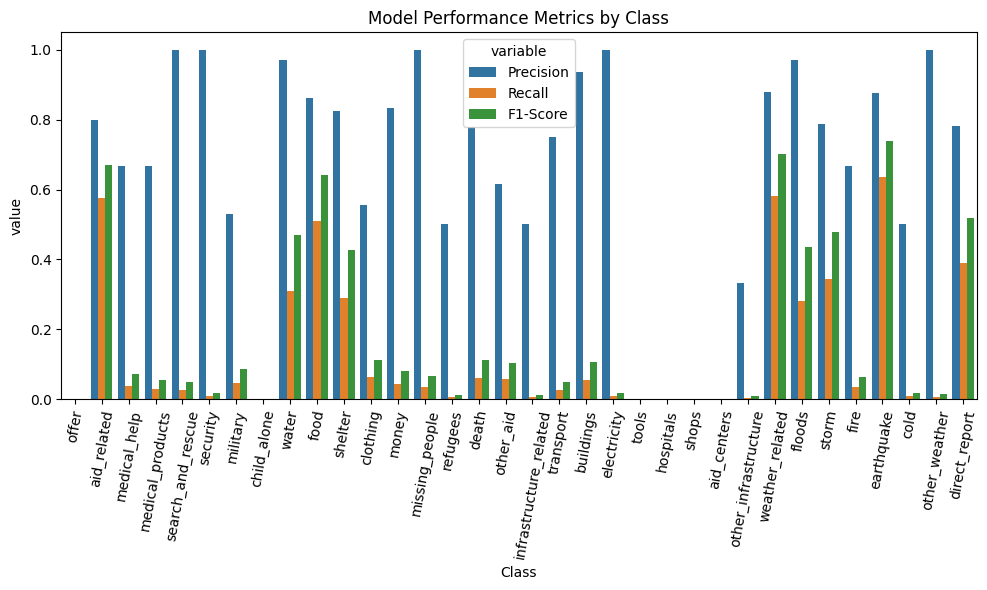

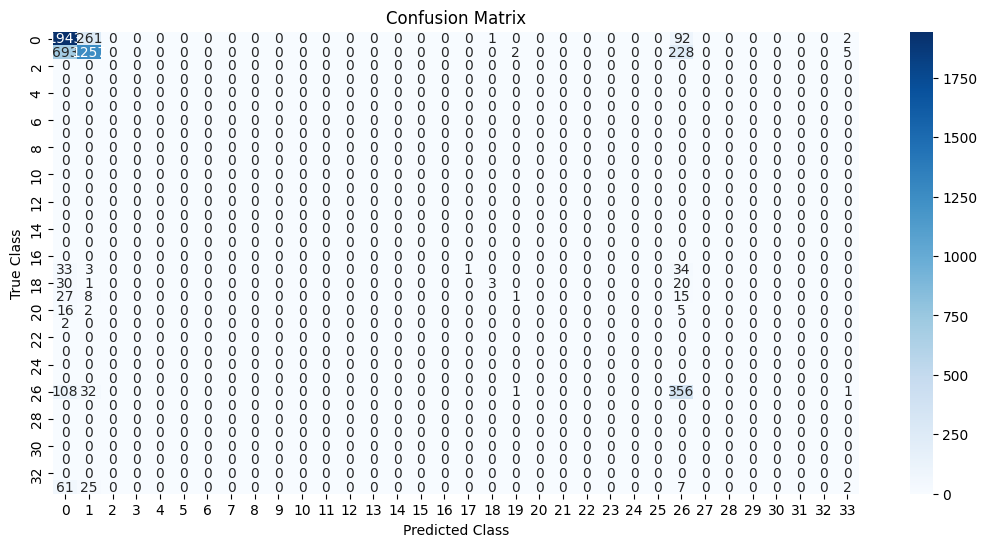

----------------------------------------------------------------------------------------------------

Class Distribution in Test Set:
----------------------------------------------------------------------------------------------------
offer: 2299 samples
aid_related: 2185 samples
infrastructure_related: 71 samples
transport: 54 samples
buildings: 51 samples
electricity: 23 samples
tools: 2 samples
weather_related: 498 samples
direct_report: 95 samples




In [185]:
y_pred, metrics_df = evaluate_model(model, X_test, y_test, classes)

### 6. Improve your model
Use grid search to find better parameters. 

In [186]:
# help(sklearn)
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import FeatureUnion,Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [187]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        """
        Generates a new binary input feature, (1 if the first word in the input text is a verb, 0 otherwise),
        This feature will be combined with the input text data processed through a TF-IDF transformer pipeline.
        """
        self.run_count = 1
        print("Start Verb Extractor running...")

    def starting_verb(self, text):
        """
        Tags the first word of the tokenized input text.
        
        Args:
            text(string): a row input text message.
        returns:
             tag(integer): 1 if the first word is a verb, 0 otherwise.
        """
        try:
            
            # print("\n\nText:", text)
            sentence_list = nltk.sent_tokenize(text)
            for sentence in sentence_list:
                # Tokenize the sentence
                text_tokens = tokenize(sentence)
                
                if text_tokens:
                    # Get the POS (parts of speech) of the words in the text.
                    first_word, first_tag = nltk.pos_tag(text_tokens)[0]
                    
                    # Check if the first word is a Verb or 'RT' (retweet). 
                    if first_tag in ['VB', 'VBP', 'UH'] or first_word == 'RT':
                        # print("\nVerb, Tag: ",first_tag, ", First Word: ",first_word)
                        tag = 1
                        return tag
                    else:
                        # print(f"\nNon-verb, Tag: {first_tag}, First Word: ,{first_word}")
                        tag = 0
                        return tag
                else:
                    # print(f'Empty Text Tokens, {text_tokens} in "{sentence}"')
                    pass
            
            # If no sentences were found in the entire text.
            self.run_count += 1
            print(f"Empty Text ({self.run_count}): ", sentence_list)
            tag = 0
            return tag
        
        except IndexError as e:
            print(f"IndexError: {e}")
            print(f"Text causing issue: {text}")
            tag = 0
            return tag
    
        except Exception as e:
            print(f"Unexpected error: {e}")
            print(f"Text causing issue: {text}")
            tag = 0
            return tag
    

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        """
        Transform method.
        
        Args:
            X(numpy.ndarray):input column vector of text messages. Each row is a 
                             sample text message.
        returns:
            df_array(numpy.ndarray):a new column binary vector. Each row is a 
                             1 or 0 (1 if the first word in the corresponding 
                             row in the input column vector is a verb, and 0,
                             otherwise).
        """
        X_tagged = pd.Series(X).apply(self.starting_verb)
        df_array = pd.DataFrame(X_tagged).values # converts to a 2D numpy array.
        # df = X_tagged.values # removing this because the hstack fails.
        
        # Log information about the transformation
        print("\n\nFeature Extraction and Text Transformation Complete:")
        print("Extracted/New feature shape:", df_array.shape)
        print("Input feature shape: ", X.shape)
        
        return df_array

In [188]:
def build_model():
    """
    Constructs an ML pipeline for processing text data using a CountVectorizer and 
    TF-IDF transformer, followed by a multi-output classifier with Random Forest.

    The pipeline is designed for multi-label classification and uses GridSearchCV
    to fine-tune hyperparameters, such as n-gram range and Random Forest parameters.

    Returns:
        model (GridSearchCV): A grid search object for training and evaluation, 
        which includes feature extraction, transformation, and a classifier.
    """
    
    text_pipeline = Pipeline([
        ("vect", CountVectorizer(tokenizer=tokenize)),
        ("tfidf", TfidfTransformer())
    ])
    
     
    model = Pipeline([
        ("features", text_pipeline),
        ("clf", MultiOutputClassifier(RandomForestClassifier()))
    ])
    
    # specify parameters for grid search
    parameters = {
        'features__vect__ngram_range': ((1, 1), (1, 2)),
        'clf__estimator__n_estimators': [10, 25, 50],
        'clf__estimator__min_samples_split': [2, 3, 4]
    }
    
    # create grid search object
    cv = GridSearchCV(estimator=model, param_grid=parameters, verbose=2, cv=3, error_score='raise')
    
    return cv

In [189]:
def inspect_pipeline(model, X_train):
    """
    Safely inspect each step of a fitted pipeline.
    
    Args:
        model: Fitted GridSearchCV object
        X_train: Training data to inspect transformations
    """
    if not isinstance(model, GridSearchCV):
        print("Warning: Model is not a GridSearchCV instance")
        return
    
    print("Best Parameters:", model.best_params_)
    print("\nInspecting Pipeline Steps:")
    
    # Access the fitted pipeline
    pipeline = model.best_estimator_
    current_data = X_train
    
    # Iterate through named steps
    for name, transformer in pipeline.named_steps.items():
        print(f"\nStep: {name}")
        print(f"Input shape: {current_data.shape}")
        
        try:
            # Check if step has transform method
            if hasattr(transformer, 'transform'):
                current_data = transformer.transform(current_data)
                print(f"Output shape: {current_data.shape}")
                
                # Print feature names if available
                if hasattr(transformer, 'get_feature_names_out'):
                    features = transformer.get_feature_names_out()
                    print(f"First few features: {features[:5]}")
                    
            else:
                print(f"Note: {name} doesn't have transform method (might be final estimator)")
                
            # Print additional info for specific transformer types
            if hasattr(transformer, 'n_features_in_'):
                print(f"Number of input features: {transformer.n_features_in_}\n")
                
        except Exception as e:
            print(f"Error processing {name}: {str(e)}\n")
            continue
    
    return current_data

In [190]:
pprint(audit_ml_data(X_train, y_train, X_test, y_test))

=== Dataset Audit Report ===

Shapes:
Training set, X: (21108,)
Training set, y: (21108, 34)
Test set, X: (5278,)
Test set, y: (5278, 34)

Data Types:
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>

Target Information:
Unique y values: [ 0  1 17 18 19 20 21 26 33]


Class Distribution in Training Set:
'Class 0: 9412 samples'
'Class 1: 8659 samples'
'Class 17: 297 samples'
'Class 18: 170 samples'
'Class 19: 166 samples'
'Class 20: 89 samples'
'Class 21: 2 samples'
'Class 26: 1965 samples'
'Class 33: 348 samples'


{'data_types': {'X_train_type': <class 'numpy.ndarray'>,
                'y_train_type': <class 'numpy.ndarray'>},
 'target_info': {'unique_values': array([ 0,  1, 17, 18, 19, 20, 21, 26, 33])},
 'test_shapes': {'X_test': (5278,), 'y_test': (5278, 34)},
 'train_shapes': {'X_train': (21108,), 'y_train': (21108, 34)}}


In [191]:
new_model = build_model()
new_model.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__vect__ngram_range=(1, 1); total time=  13.9s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__vect__ngram_range=(1, 1); total time=  12.7s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__vect__ngram_range=(1, 1); total time=  12.9s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__vect__ngram_range=(1, 2); total time=  23.8s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__vect__ngram_range=(1, 2); total time=  24.1s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__vect__ngram_range=(1, 2); total time=  24.4s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, features__vect__ngram_range=(1, 1); total time=  27.5s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, features__vect__ngram_range=(1, 1); total time=  28.0s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, features__vect__ngram_range=(1, 1); total time=  27.1s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, features__vect__ngram_range=(1, 2); total time=  57.6s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, features__vect__ngram_range=(1, 2); total time=  57.3s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, features__vect__ngram_range=(1, 2); total time=  56.4s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 1); total time=  55.7s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 1); total time=  56.7s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 1); total time=  55.1s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 2); total time= 1.8min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 2); total time= 1.9min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 2); total time= 1.8min


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, features__vect__ngram_range=(1, 1); total time=  12.1s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, features__vect__ngram_range=(1, 1); total time=  11.9s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, features__vect__ngram_range=(1, 1); total time=  12.1s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, features__vect__ngram_range=(1, 2); total time=  20.6s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, features__vect__ngram_range=(1, 2); total time=  20.7s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, features__vect__ngram_range=(1, 2); total time=  20.8s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=25, features__vect__ngram_range=(1, 1); total time=  28.9s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=25, features__vect__ngram_range=(1, 1); total time=  28.4s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=25, features__vect__ngram_range=(1, 1); total time=  27.0s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=25, features__vect__ngram_range=(1, 2); total time=  52.5s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=25, features__vect__ngram_range=(1, 2); total time=  48.9s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=25, features__vect__ngram_range=(1, 2); total time=  49.2s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=50, features__vect__ngram_range=(1, 1); total time=  51.9s


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/var/folders/w4/j1dy6gvs5mv5_x5pw5lfbn8r0000gp/T/ipykernel_80639/4262558252.py:18: SyntaxWarning: invalid escape sequence '\('
  url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'


KeyboardInterrupt: 

In [605]:
# ensure the outputs of each transformer is of the shape we expect.
output_data = inspect_pipeline(new_model, X_train)

Best Parameters: {'clf__estimator__min_samples_split': 2, 'clf__estimator__n_estimators': 50, 'features__vect__ngram_range': (1, 2)}

Inspecting Pipeline Steps:

Step: features
Input shape: (21108,)
Output shape: (21108, 226597)
First few features: ['0' '0 0' '0 00' '0 06' '0 1']

Step: clf
Input shape: (21108, 226597)
Note: clf doesn't have transform method (might be final estimator)
Number of input features: 226597



### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

Best parameters found:
{'clf__estimator__min_samples_split': 2,
 'clf__estimator__n_estimators': 50,
 'features__vect__ngram_range': (1, 2)}

Best cross-validation score: 0.4164297896532121
Overall Sample-wise Accuracy: 0.679
Class 0 accuracy: 0.7888
Class 1 accuracy: 0.0000
Class 2 accuracy: 0.5533
Class 3 accuracy: nan
Class 4 accuracy: nan
Class 5 accuracy: nan
Class 6 accuracy: nan
Class 7 accuracy: nan
Class 8 accuracy: nan
Class 9 accuracy: nan
Class 10 accuracy: nan
Class 11 accuracy: nan
Class 12 accuracy: nan
Class 13 accuracy: nan
Class 14 accuracy: nan
Class 15 accuracy: nan
Class 16 accuracy: nan
Class 17 accuracy: nan
Class 18 accuracy: 0.0000
Class 19 accuracy: 0.0370
Class 20 accuracy: 0.0800
Class 21 accuracy: 0.0476
Class 22 accuracy: 0.0000
Class 23 accuracy: nan
Class 24 accuracy: nan
Class 25 accuracy: nan
Class 26 accuracy: nan
Class 27 accuracy: 0.6570
Class 28 accuracy: nan
Class 29 accuracy: nan
Class 30 accuracy: nan
Class 31 accuracy: nan
Class 32 accuracy: na

/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encount

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5158
           1       0.80      0.03      0.06       120

    accuracy                           0.98      5278
   macro avg       0.89      0.52      0.53      5278
weighted avg       0.97      0.98      0.97      5278


Detailed metrics for other_weather:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4992
           1       0.45      0.02      0.03       286

    accuracy                           0.95      5278
   macro avg       0.70      0.51      0.50      5278
weighted avg       0.92      0.95      0.92      5278


Detailed metrics for direct_report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      4255
           1       0.78      0.36      0.49      1023

    accuracy                           0.86      5278
   macro avg       0.82      0.67      0.70      5278


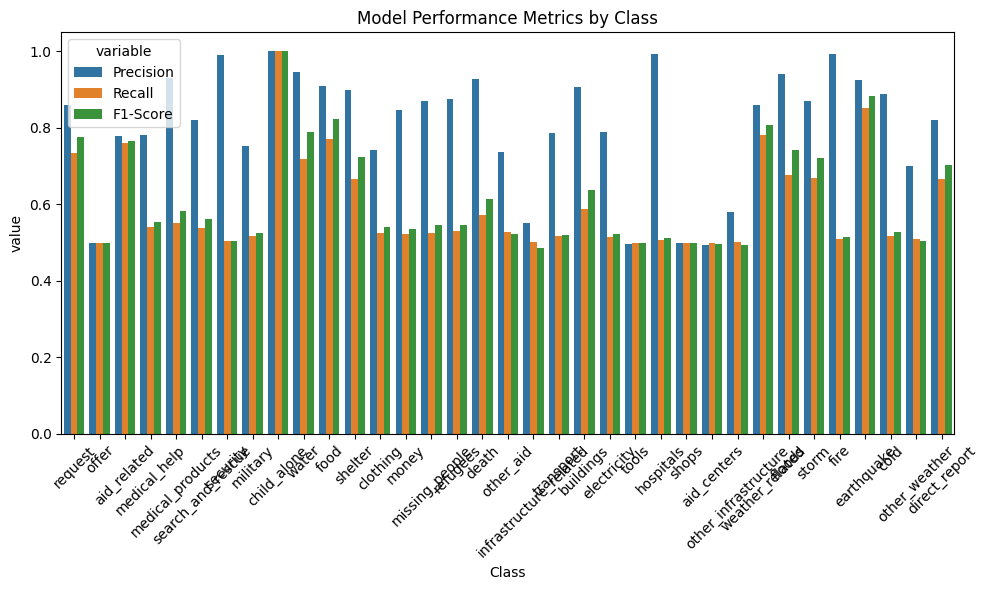

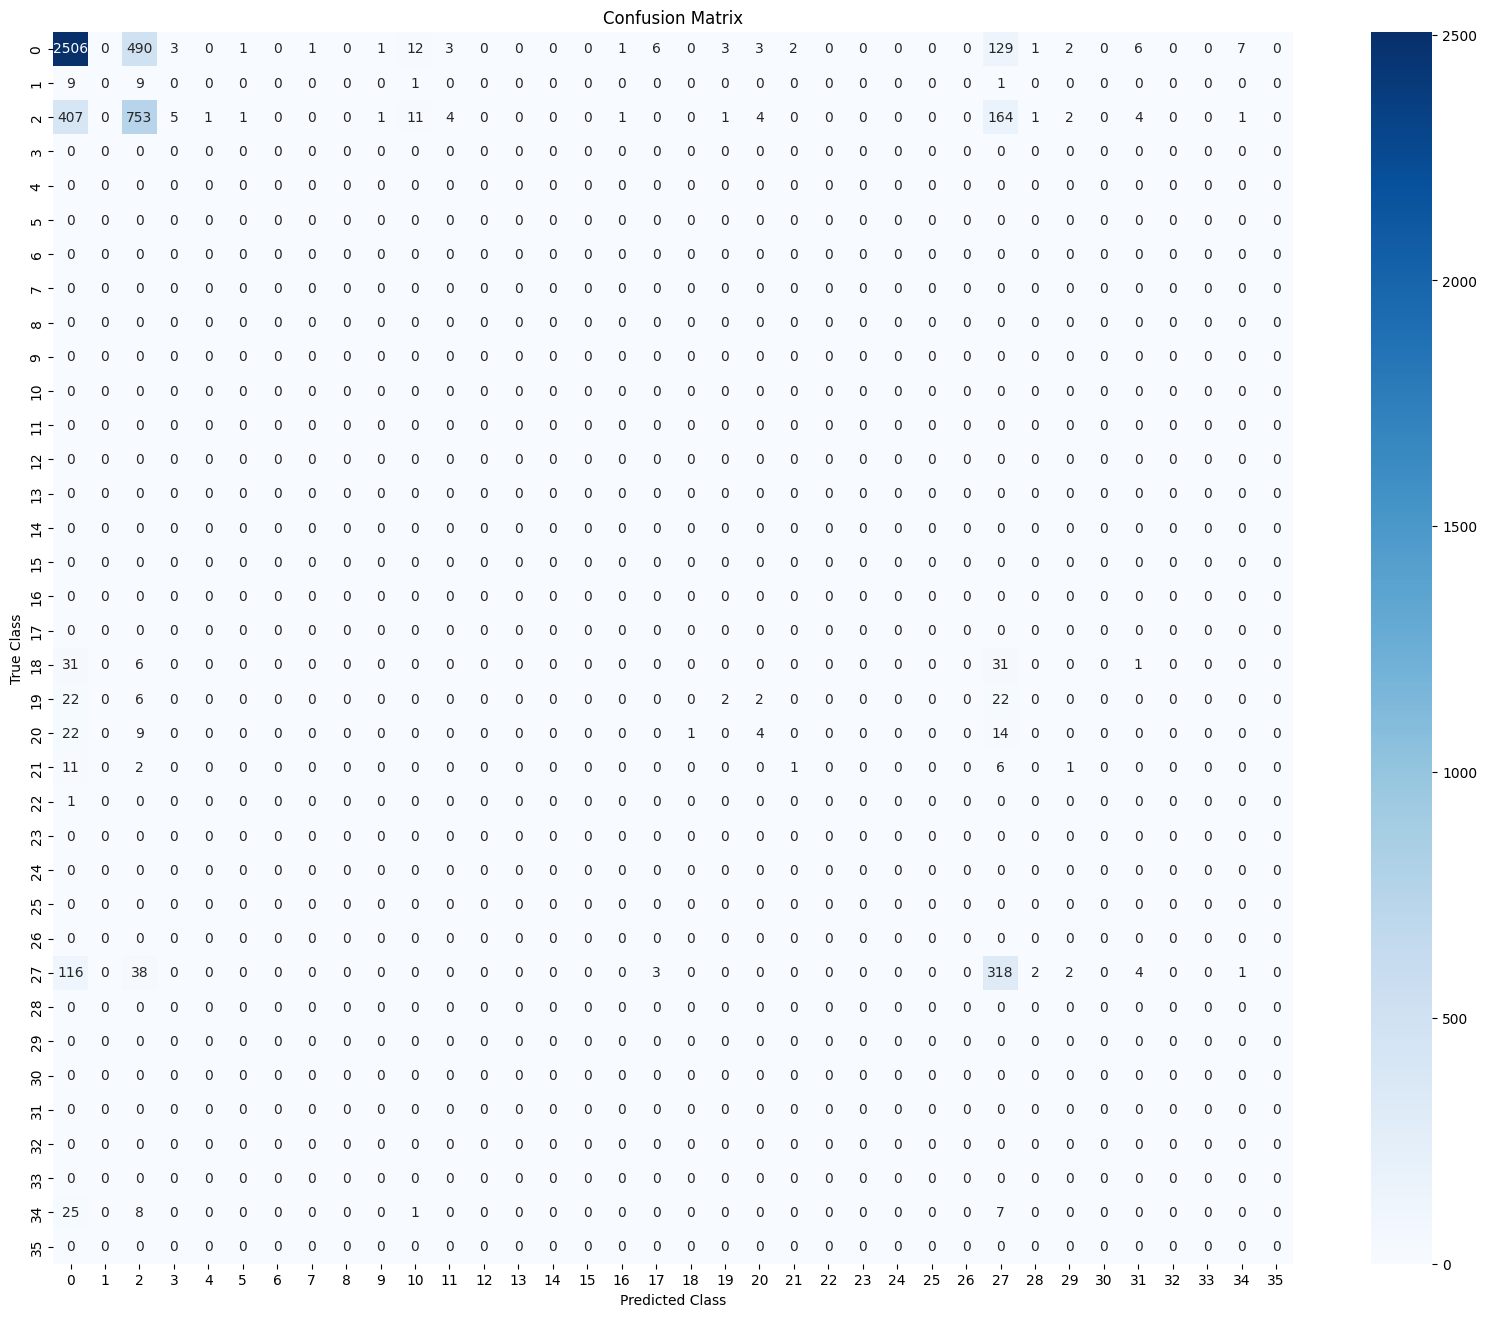


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      3177
           1       0.00      0.00      0.00        20
           2       0.57      0.55      0.56      1361
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          18       0.00      0.00      0.00        69
          19       0.33      0.04      0.07        54
          20       0.31      0.08      0.13        50
          21       0.33      0.05      0.08        21
          22       0.00      0.00      0.00         1
   

/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(

0     3177
2     1361
27     484
18      69
19      54
20      50
34      41
21      21
1       20
22       1
Name: count, dtype: int64

,Class,Precision,Recall,F1-Score
0,request,0.859734,0.735421,0.776859
1,offer,0.498105,0.500000,0.499051
2,aid_related,0.779133,0.760198,0.765331
3,medical_help,0.781421,0.539708,0.553804
4,medical_products,0.929679,0.552427,0.582315
5,search_and_rescue,0.819360,0.537150,0.560426
6,security,0.990051,0.504717,0.504321
7,military,0.751662,0.517639,0.524920
8,child_alone,1.000000,1.000000,1.000000
9,water,0.946684,0.718585,0.788622


In [606]:
y_pred, metrics_df = evaluate_model(new_model, X_test, y_test, classes)

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [607]:
def build_model():
    """
    Constructs an ML pipeline using FeatureUnion to add a new binary feature.
    The feature checks if the first word in each text is a verb (1 if a verb, 0 otherwise),
    and combines this feature with the text data processed through a TF-IDF transformer pipeline.
    The combined feature matrix is used to train the model to enhance its performance.

    Returns:
        model (Pipeline): A scikit-learn pipeline object for training and evaluation, 
        which includes feature extraction, transformation, and a classifier.
    """
    
    text_pipeline = Pipeline([
        ("vect", CountVectorizer(tokenizer=tokenize)),
        ("tfidf", TfidfTransformer())
    ])
    
    features = FeatureUnion([
        ("text_pipeline",text_pipeline),
        ("starting_verb", StartingVerbExtractor())
    ])
    
    model = Pipeline([
        ("features", features),
        ("clf", MultiOutputClassifier(RandomForestClassifier()))
])
    
    # specify parameters for grid search
    parameters = {
        'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
        'clf__estimator__n_estimators': [10, 25, 50],
        'clf__estimator__min_samples_split': [2, 3, 4]
    }
    
    # create grid search object
    cv = GridSearchCV(estimator=model, param_grid=parameters, verbose=2, cv=3, error_score='raise')
    
    return cv

In [608]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# class_weight='balanced'

# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)



In [609]:
pprint(audit_ml_data(X_train, y_train, X_test, y_test))

=== Dataset Audit Report ===

Shapes:
Training set, X: (19789,)
Training set, y: (19789, 35)
Test set, X: (6597,)
Test set, y: (6597, 35)

Data Types:
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>

Target Information:
Unique y values: [ 0  1  2 18 19 20 21 22 27 34]

{'data_types': {'X_train_type': <class 'numpy.ndarray'>,
                'y_train_type': <class 'numpy.ndarray'>},
 'target_info': {'unique_values': array([ 0,  1,  2, 18, 19, 20, 21, 22, 27, 34])},
 'test_shapes': {'X_test': (6597,), 'y_test': (6597, 35)},
 'train_shapes': {'X_train': (19789,), 'y_train': (19789, 35)}}


In [610]:
new_model = build_model()
new_model.fit(X_train, y_train)

Start Verb Extractor running...
Start Verb Extractor running...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13192, 1)
Input feature shape:  (13192,)
Empty Text (3):  []
Empty Text (4):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  18.7s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  18.7s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  18.1s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13192, 1)
Input feature shape:  (13192,)
Empty Text (3):  []
Empty Text (4):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  28.2s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  29.5s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  30.1s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13192, 1)
Input feature shape:  (13192,)
Empty Text (3):  []
Empty Text (4):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 1); total time=  35.0s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 1); total time=  33.1s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 1); total time=  34.4s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13192, 1)
Input feature shape:  (13192,)
Empty Text (3):  []
Empty Text (4):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 2); total time=  57.6s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 2); total time=  56.8s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 2); total time=  55.7s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13192, 1)
Input feature shape:  (13192,)
Empty Text (3):  []
Empty Text (4):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 1); total time=  57.1s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 1); total time=  57.8s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 1); total time=  57.6s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13192, 1)
Input feature shape:  (13192,)
Empty Text (3):  []
Empty Text (4):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 2); total time= 1.7min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 2); total time= 1.7min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 2); total time= 1.7min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13192, 1)
Input feature shape:  (13192,)
Empty Text (3):  []
Empty Text (4):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  19.2s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  17.6s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  17.5s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13192, 1)
Input feature shape:  (13192,)
Empty Text (3):  []
Empty Text (4):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  24.5s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  25.0s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  24.5s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13192, 1)
Input feature shape:  (13192,)
Empty Text (3):  []
Empty Text (4):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 1); total time=  30.1s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 1); total time=  30.4s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 1); total time=  30.8s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13192, 1)
Input feature shape:  (13192,)
Empty Text (3):  []
Empty Text (4):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 2); total time=  50.1s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 2); total time=  52.2s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 2); total time=  51.3s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13192, 1)
Input feature shape:  (13192,)
Empty Text (3):  []
Empty Text (4):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 1); total time=  54.2s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 1); total time=  55.0s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 1); total time=  55.1s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13192, 1)
Input feature shape:  (13192,)
Empty Text (3):  []
Empty Text (4):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 2); total time= 1.5min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 2); total time= 1.6min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 2); total time= 1.5min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13192, 1)
Input feature shape:  (13192,)
Empty Text (3):  []
Empty Text (4):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  17.4s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  17.4s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  17.5s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13192, 1)
Input feature shape:  (13192,)
Empty Text (3):  []
Empty Text (4):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  23.9s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  24.6s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  24.4s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13192, 1)
Input feature shape:  (13192,)
Empty Text (3):  []
Empty Text (4):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 1); total time=  30.2s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 1); total time=  30.3s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 1); total time=  30.4s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13192, 1)
Input feature shape:  (13192,)
Empty Text (3):  []
Empty Text (4):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 2); total time=  46.5s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 2); total time=  48.0s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 2); total time=  47.7s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13192, 1)
Input feature shape:  (13192,)
Empty Text (3):  []
Empty Text (4):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 1); total time=  51.2s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 1); total time=  51.6s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 1); total time=  51.5s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13192, 1)
Input feature shape:  (13192,)
Empty Text (3):  []
Empty Text (4):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 2); total time= 1.4min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 2); total time= 1.4min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (13193, 1)
Input feature shape:  (13193,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6596, 1)
Input feature shape:  (6596,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 2); total time= 1.4min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  []
Empty Text (3):  ['          .']
Empty Text (4):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (19789, 1)
Input feature shape:  (19789,)


GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('text_pipeline',
                                                                        Pipeline(steps=[('vect',
                                                                                         CountVectorizer(tokenizer=<function tokenize at 0x53f309940>)),
                                                                                        ('tfidf',
                                                                                         TfidfTransformer())])),
                                                                       ('starting_verb',
                                                                        StartingVerbExtractor())])),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier()))]),
             param_grid={'clf__estimator__min_samples_split': [2, 3, 4],
                         'clf__estimator__n_estimators': [10, 25, 50],
                         'features__text_pipeline__vect__ngram_range': ((1, 1),
                                                                        (1,
                                                                         2))},
             verbose=2)

In [611]:
# ensure the outputs of each transformer is of the shape we expect.
output_data = inspect_pipeline(new_model, X_train)

Best Parameters: {'clf__estimator__min_samples_split': 2, 'clf__estimator__n_estimators': 50, 'features__text_pipeline__vect__ngram_range': (1, 2)}

Inspecting Pipeline Steps:

Step: features
Input shape: (19789,)
Empty Text (5):  []
Empty Text (6):  ['          .']
Empty Text (7):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (19789, 1)
Input feature shape:  (19789,)
Output shape: (19789, 214454)
Error processing features: Transformer starting_verb (type StartingVerbExtractor) does not provide get_feature_names_out.


Step: clf
Input shape: (19789, 214454)
Note: clf doesn't have transform method (might be final estimator)
Number of input features: 214454



Empty Text (8):  []
Empty Text (9):  ['//// // @:@']
Empty Text (10):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (6597, 1)
Input feature shape:  (6597,)
Best parameters found:
{'clf__estimator__min_samples_split': 2,
 'clf__estimator__n_estimators': 50,
 'features__text_pipeline__vect__ngram_range': (1, 2)}

Best cross-validation score: 0.41361394247264144
Overall Sample-wise Accuracy: 0.696
Class 0 accuracy: 0.7979
Class 1 accuracy: 0.0270
Class 2 accuracy: 0.5696
Class 3 accuracy: nan
Class 4 accuracy: nan
Class 5 accuracy: nan
Class 6 accuracy: nan
Class 7 accuracy: nan
Class 8 accuracy: nan
Class 9 accuracy: nan
Class 10 accuracy: nan
Class 11 accuracy: nan
Class 12 accuracy: nan
Class 13 accuracy: nan
Class 14 accuracy: nan
Class 15 accuracy: nan
Class 16 accuracy: nan
Class 17 accuracy: nan
Class 18 accuracy: 0.0109
Class 19 accuracy: 0.1273
Class 20 accuracy: 0.0370
Class 21 accuracy: 0.0800
Cla

/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encount


Detailed metrics for storm:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      6002
           1       0.78      0.41      0.54       595

    accuracy                           0.94      6597
   macro avg       0.86      0.70      0.75      6597
weighted avg       0.93      0.94      0.93      6597


Detailed metrics for fire:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6526
           1       0.67      0.03      0.05        71

    accuracy                           0.99      6597
   macro avg       0.83      0.51      0.52      6597
weighted avg       0.99      0.99      0.98      6597


Detailed metrics for earthquake:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6006
           1       0.90      0.73      0.81       591

    accuracy                           0.97      6597
   macro avg       0.94      0.86    

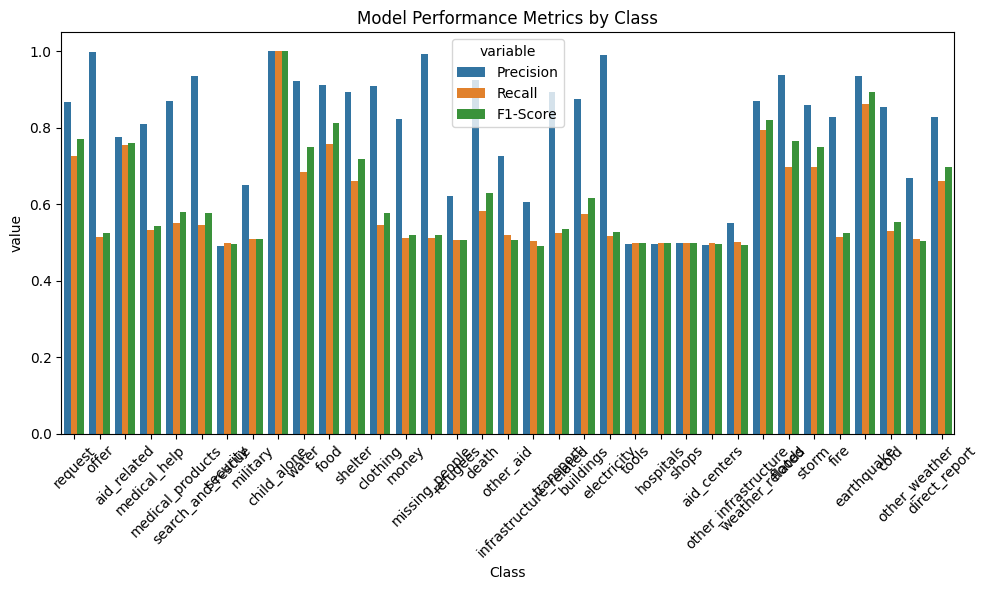

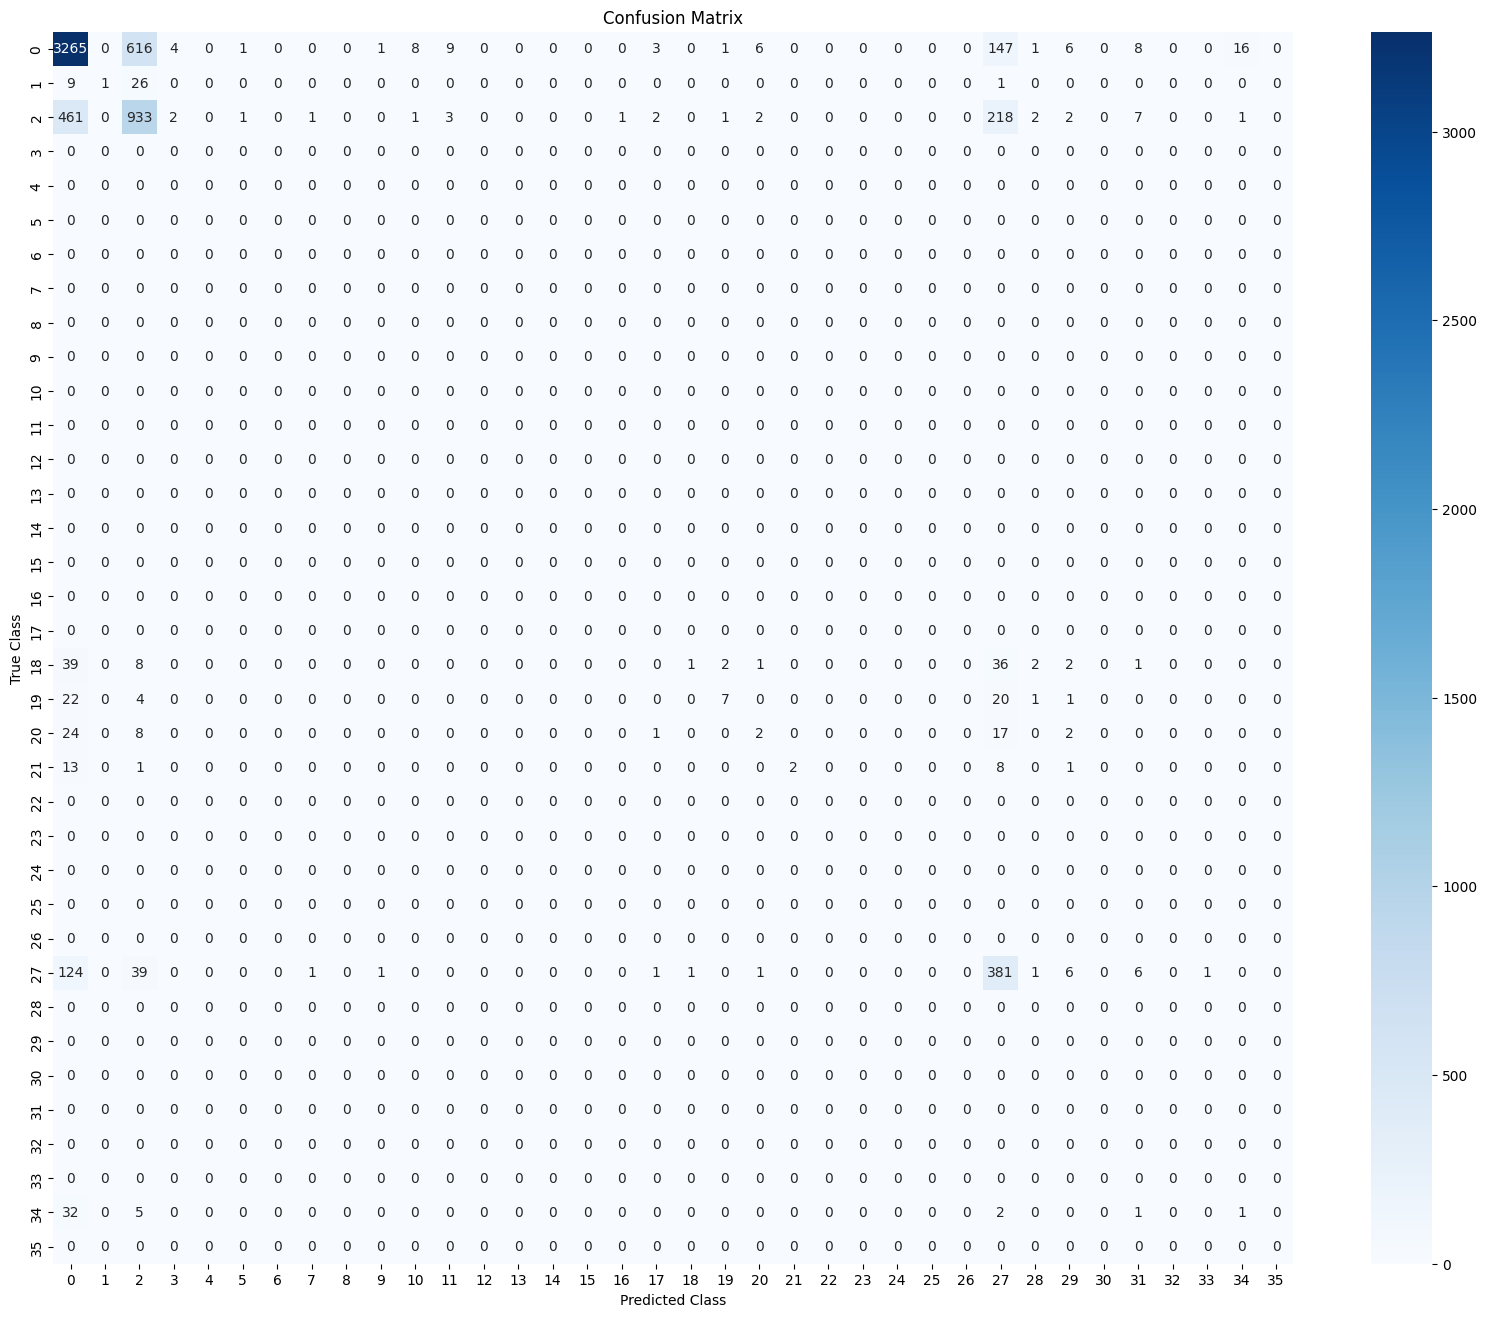


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      4092
           1       1.00      0.03      0.05        37
           2       0.57      0.57      0.57      1638
           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          18       0.50      0.01      0.02        92
          19       0.64      0.13      0.21        55
          20       0.17      0.04      0.06        54
          21       1.00      0.08      0.15        25
          27       0.46      0.68      0.55       563
          28       0.00      0.00      0.00         0
   

/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0     3177
2     1361
27     484
18      69
19      54
20      50
34      41
21      21
1       20
22       1
Name: count, dtype: int64

,Class,Precision,Recall,F1-Score
0,request,0.868784,0.725696,0.770329
1,offer,0.997271,0.513514,0.524948
2,aid_related,0.776393,0.755213,0.760911
3,medical_help,0.809867,0.533911,0.544507
4,medical_products,0.871042,0.551007,0.579919
5,search_and_rescue,0.936696,0.546476,0.577689
6,security,0.491283,0.499923,0.495565
7,military,0.651405,0.509130,0.510380
8,child_alone,1.000000,1.000000,1.000000
9,water,0.923840,0.684025,0.750286


In [612]:
y_pred, metrics_df = evaluate_model(new_model, X_test, y_test, classes)

### 9. Export your model as a pickle file

In [613]:
import pickle 

# Step 2: Export the model using pickle
with open('train_classifier.pkl', 'wb') as model_file:
    pickle.dump(new_model, model_file)

print("Model exported successfully!")

Model exported successfully!


### 10. Use this notebook to complete `train_classifier.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [619]:
def main():
    """
    """
    # load data from database
    engine =  create_engine('sqlite:///DisasterTweets.db')

    text_inputs, response_labels, df = load_data(table_name="cleandata", conn_engine=engine)
    X, y = text_inputs.values, response_labels.values
    
    # load data from database
    engine =  create_engine('sqlite:///DisasterTweets.db')
    
    # View the first few rows of the DataFrame
    display(df.head(3))

    # Get class names from the dataset
    classes = response_labels.columns
    print(f"\nlabels: {list(classes)}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=41)
    
    # Inspect the training dataset
    pprint(audit_ml_data(X_train, y_train))
    
    pprint(audit_ml_data(X_train, y_train, X_test, y_test))
    
    model = build_model()
    model.fit(X_train, y_train)
    
    # ensure the outputs of each transformer is of the shape we expect.
    output_data = inspect_pipeline(model, X_train)
    
    y_pred, metrics_df = evaluate_model(model, X_test, y_test, classes) 
    
    
    

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



labels: ['request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']
=== Dataset Audit Report ===

Shapes:
Training set, X: (21108,)
Training set, y: (21108, 35)

Data Types:
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>

Target Information:
Unique y values: [ 0  1  2 18 19 20 21 22 27 34]

{'data_types': {'X_train_type': <class 'numpy.ndarray'>,
                'y_train_type': <class 'numpy.ndarray'>},
 'target_info': {'unique_values': array([ 0,  1,  2, 18, 19, 20, 21, 22, 27, 34])},
 'train_shapes': {'X_train': (21108,), 'y_train': (21108, 35)}}
===

/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  20.5s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['          .']
Empty Text (3):  ['//// // @:@']
Empty Text (4):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (6):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  20.1s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  20.2s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  30.1s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['          .']
Empty Text (3):  ['//// // @:@']
Empty Text (4):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (6):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  30.9s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  33.9s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 1); total time=  39.2s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['          .']
Empty Text (3):  ['//// // @:@']
Empty Text (4):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (6):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 1); total time=  37.9s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 1); total time=  37.7s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 2); total time= 1.1min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['          .']
Empty Text (3):  ['//// // @:@']
Empty Text (4):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (6):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 2); total time= 1.2min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 2); total time= 1.1min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 1); total time= 1.1min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['          .']
Empty Text (3):  ['//// // @:@']
Empty Text (4):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (6):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 1); total time= 1.1min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 1); total time= 1.1min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 2); total time= 2.0min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['          .']
Empty Text (3):  ['//// // @:@']
Empty Text (4):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (6):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 2); total time= 2.1min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 2); total time= 2.0min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  20.2s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['          .']
Empty Text (3):  ['//// // @:@']
Empty Text (4):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (6):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  19.9s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  20.1s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  29.3s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['          .']
Empty Text (3):  ['//// // @:@']
Empty Text (4):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (6):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  27.8s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  26.8s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 1); total time=  33.9s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['          .']
Empty Text (3):  ['//// // @:@']
Empty Text (4):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (6):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 1); total time=  32.7s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 1); total time=  32.7s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 2); total time=  58.8s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['          .']
Empty Text (3):  ['//// // @:@']
Empty Text (4):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (6):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 2); total time=  52.6s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 2); total time=  52.1s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 1); total time=  56.8s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['          .']
Empty Text (3):  ['//// // @:@']
Empty Text (4):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (6):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 1); total time=  56.5s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 1); total time=  56.2s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 2); total time= 1.6min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['          .']
Empty Text (3):  ['//// // @:@']
Empty Text (4):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (6):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 2); total time= 1.6min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=3, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 2); total time= 1.6min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  17.6s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['          .']
Empty Text (3):  ['//// // @:@']
Empty Text (4):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (6):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  17.8s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 1); total time=  17.7s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  25.0s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['          .']
Empty Text (3):  ['//// // @:@']
Empty Text (4):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (6):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  24.5s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=10, features__text_pipeline__vect__ngram_range=(1, 2); total time=  24.8s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 1); total time=  31.2s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['          .']
Empty Text (3):  ['//// // @:@']
Empty Text (4):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (6):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 1); total time=  31.2s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 1); total time=  31.0s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 2); total time=  48.8s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['          .']
Empty Text (3):  ['//// // @:@']
Empty Text (4):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (6):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 2); total time=  48.1s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=25, features__text_pipeline__vect__ngram_range=(1, 2); total time=  48.2s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 1); total time=  53.6s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['          .']
Empty Text (3):  ['//// // @:@']
Empty Text (4):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (6):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 1); total time=  53.3s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 1); total time=  53.7s
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 2); total time= 1.5min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['          .']
Empty Text (3):  ['//// // @:@']
Empty Text (4):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (5):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (6):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 2); total time= 1.5min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (14072, 1)
Input feature shape:  (14072,)
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (7036, 1)
Input feature shape:  (7036,)
[CV] END clf__estimator__min_samples_split=4, clf__estimator__n_estimators=50, features__text_pipeline__vect__ngram_range=(1, 2); total time= 1.5min
Start Verb Extractor running...


/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Empty Text (2):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (3):  []
Empty Text (4):  ['          .']
Empty Text (5):  ['//// // @:@']
Empty Text (6):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (21108, 1)
Input feature shape:  (21108,)
Best Parameters: {'clf__estimator__min_samples_split': 2, 'clf__estimator__n_estimators': 50, 'features__text_pipeline__vect__ngram_range': (1, 2)}

Inspecting Pipeline Steps:

Step: features
Input shape: (21108,)
Empty Text (7):  ['(http://www.guardian.co.uk/global-development/2013/jan/16/somali-ngos-mogadishu-street-children)']
Empty Text (8):  []
Empty Text (9):  ['          .']
Empty Text (10):  ['//// // @:@']
Empty Text (11):  ['http://wap.sina.comhttp://wap.sina.com']


Feature Extraction and Text Transformation Complete:
Extracted/New feature shape: (21108, 1)
Input feature shape:  (21108,)
Outp

/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encount

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      4255
           1       0.80      0.36      0.50      1023

    accuracy                           0.86      5278
   macro avg       0.83      0.67      0.71      5278
weighted avg       0.85      0.86      0.84      5278


Summary of all metrics:
                     Class  Precision  Recall  F1-Score
0                  request      0.860   0.725     0.768
1                    offer      0.498   0.500     0.499
2              aid_related      0.769   0.752     0.757
3             medical_help      0.825   0.545     0.563
4         medical_products      0.893   0.554     0.584
5        search_and_rescue      0.924   0.544     0.573
6                 security      0.740   0.505     0.504
7                 military      0.829   0.523     0.535
8              child_alone      1.000   1.000     1.000
9                    water      0.940   0.717     0.786
10                    food      

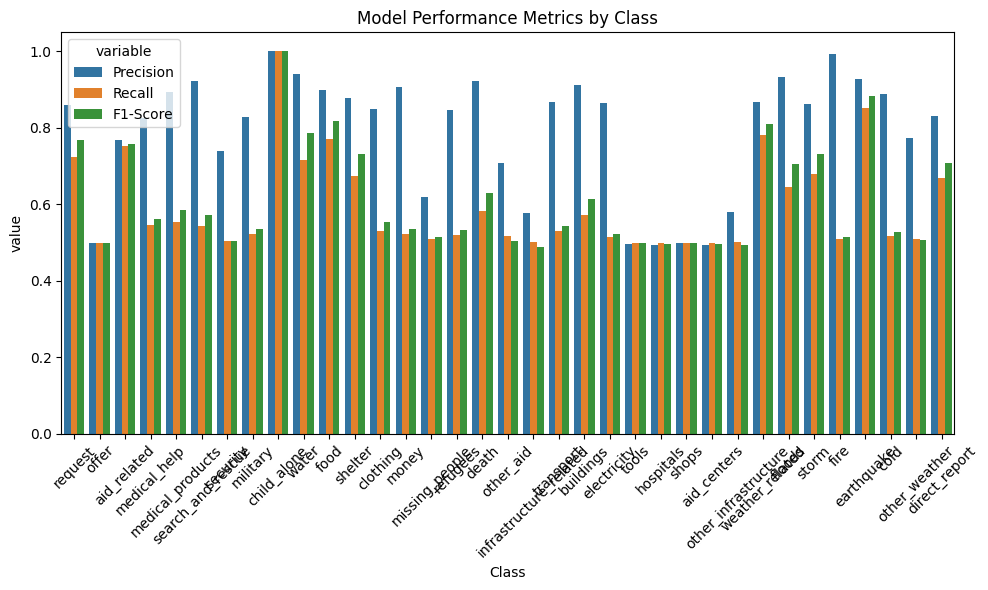

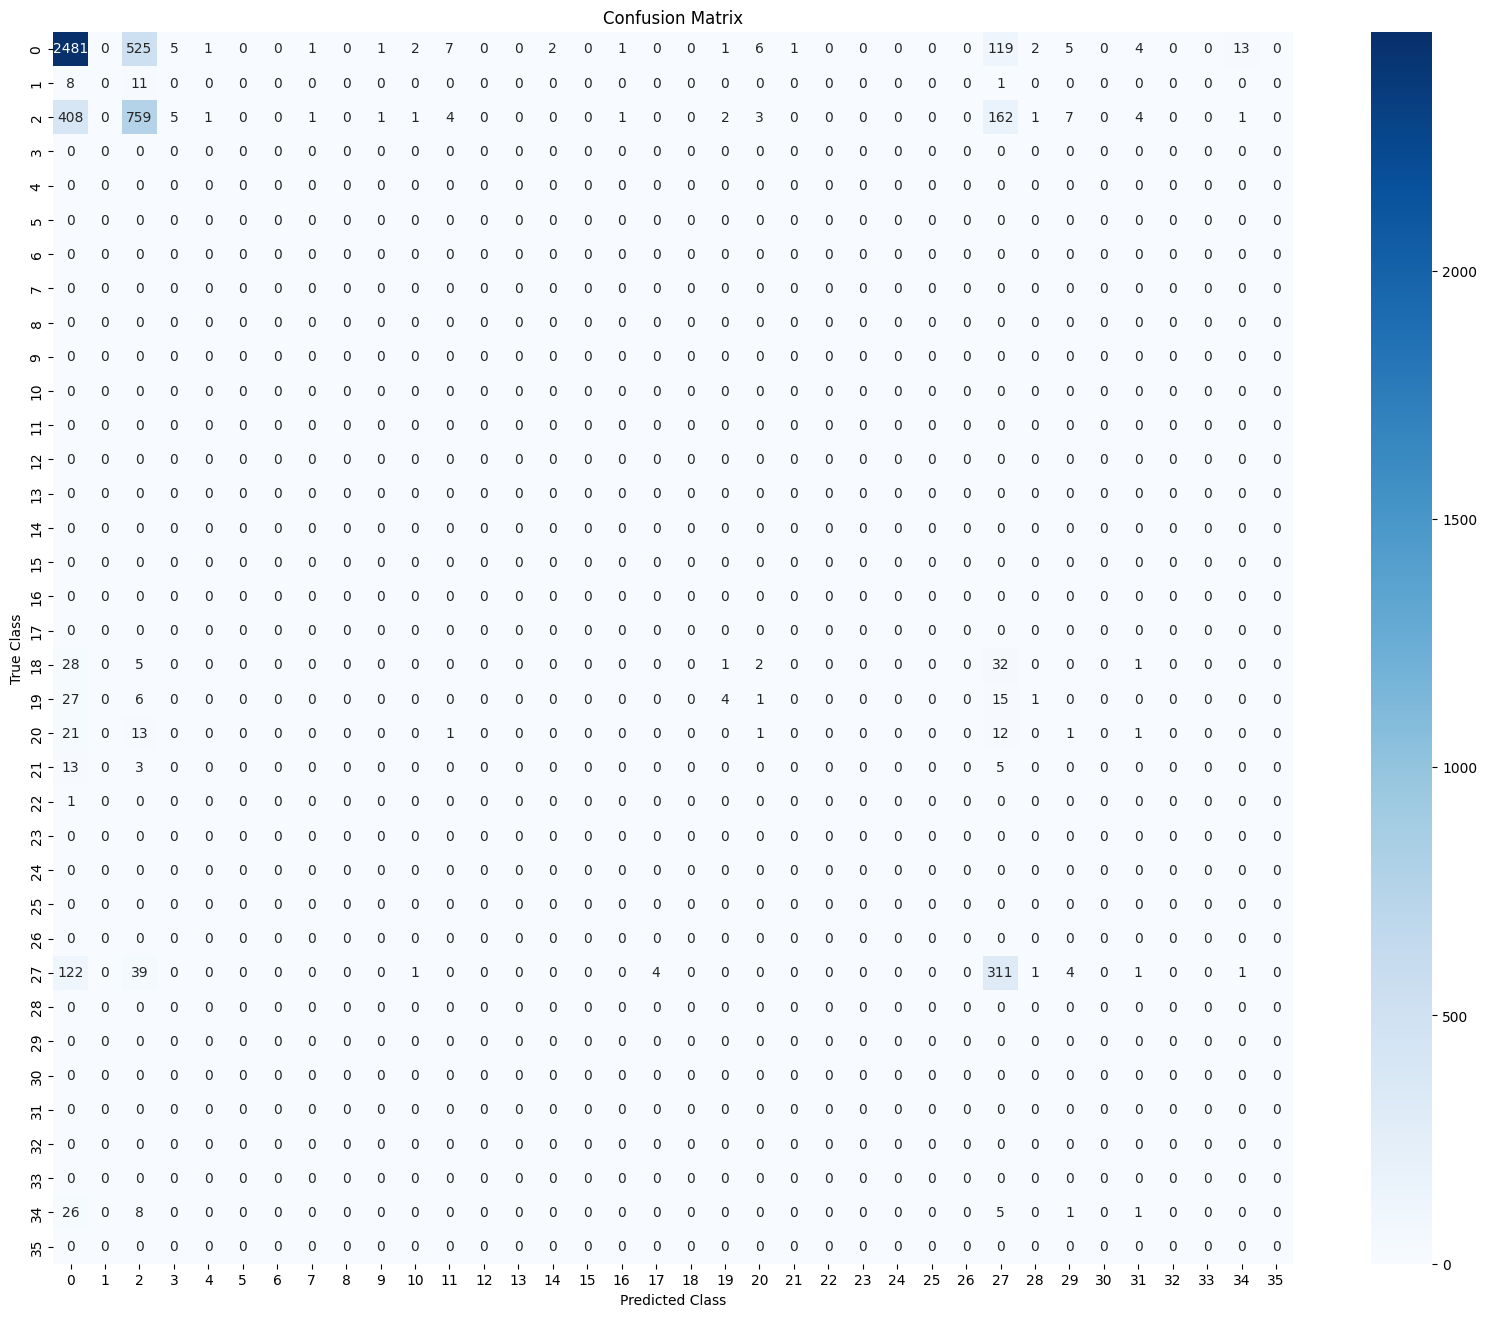


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79      3177
           1       0.00      0.00      0.00        20
           2       0.55      0.56      0.56      1361
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          18       0.00      0.00      0.00        69
          19       0.50      0.07      0.13        54
          20       0.08      0.02      0.03        50
          21       0.00      0.00      0.00        21
          22       0.00      0.00      0.00         1
   

/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emmanuele/.virtualenvs/ML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(

0     3177
2     1361
27     484
18      69
19      54
20      50
34      41
21      21
1       20
22       1
Name: count, dtype: int64

,Class,Precision,Recall,F1-Score
0,request,0.860408,0.724888,0.767874
1,offer,0.498105,0.500000,0.499051
2,aid_related,0.769447,0.752498,0.757183
3,medical_help,0.824741,0.544996,0.562865
4,medical_products,0.893298,0.553946,0.584213
5,search_and_rescue,0.923722,0.543830,0.572920
6,security,0.740049,0.504620,0.504187
7,military,0.828775,0.523044,0.534869
8,child_alone,1.000000,1.000000,1.000000
9,water,0.940438,0.716868,0.785806


In [620]:
main()